In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
!unzip '/content/drive/MyDrive/Brain Tumor/Brain_Tumor.zip'

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

# **Import Libraries**

In [2]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.optimizers import legacy
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization,MaxPooling2D,Conv2D,Dense,Dropout,Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img

In [ ]:
SAVE = True
SEED = 123

tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# # Data Visualization updates
# %config InlineBackend.figure_format = 'retina'
# plt.rcParams["figure.figsize"] = (16, 10)
# plt.rcParams.update({'font.size': 14})

# Data Classifications
classes = os.listdir('/content/Training')
class_len = len(classes)

In [ ]:
# Function for importing data
def get_data_labels(directory, shuffle=True, random_state=0):
    """
    Function used for going into the main training directory
    whose directory has sub-class-types.
    """
    from sklearn.utils import shuffle
    import os

    # Lists to store data and labels
    data_path = []
    data_labels = []

    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue

        # Going into each folder and getting image path
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_labels.append(label)

    if shuffle:
        data_path, data_labels = shuffle(data_path, data_labels, random_state=random_state)

    return data_path, data_labels


In [ ]:
train_dir ='/content/Training'
test_dir = '/content/Testing'

train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing traing and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')

Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

## <b> 5.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Data Augmentation <b>

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)

# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)


Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
def CM(CNN_model, test_generator):
    """
    Function to return the confusion matrix of a given CNN model.
    """
    from sklearn.metrics import confusion_matrix

    # Predictions on test dataset
    predictions = CNN_model.predict(test_generator)
    predicted_categories = np.argmax(predictions, axis=1)
    true_categories = test_generator.classes

    # Create a confusion matrix
    confusion_matrix_array = confusion_matrix(true_categories, predicted_categories)

    return confusion_matrix_array


# –––––––––––––––––––––––––––––––––––––– #
#             Metric Analysis            #
# –––––––––––––––––––––––––––––––––––––– #
def calculate_metrics(confusion_matrix, categories):
    """
    Function to calculate important metrics for multi-classification problems.
    """
    # Calculating 4 different metrics
    precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
    recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
    f1_score = 2 * (precision * recall) / (precision + recall)
    accuracy = np.sum(np.diag(confusion_matrix)) / np.sum(confusion_matrix)

    # Printing the results based on each category
    for i, category in enumerate(categories):
        print(f"Class: {category.title()}")
        print(f"Precision: {precision[i]:.3f}")
        print(f"Recall: {recall[i]:.3f}")
        print(f"F1-Score: {f1_score[i]:.3f}\n")

    # Showing the total accuracy of the model
    print(f"\nAccuracy: {accuracy:.3f}")

### <b> 5.1.1 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Data Augmentation Class Indices <b>

In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


### <b> 5.1.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Showing Data Augmentation <b>

In [ ]:
def show_ImageDataGenerator(ImageDataGenerator, num_samples=5, figsize=(12, 12), save=False):
    """
    Function to viusalize how the ImageDataGenerator augments the data
    """

    # Generate augmented samples
    augmented_samples = train_generator.next()

    # Extract images from the batch
    images = augmented_samples[0][:num_samples]

    # Display the augmented images
    fig, axes = plt.subplots(1, num_samples, figsize=figsize)

    for i, ax in enumerate(axes):
        ax.imshow(images[i])
        ax.axis('off')

    plt.tight_layout()

    if save:
        plt.savefig('show_ImageDataGenerator.pdf')

    plt.show()


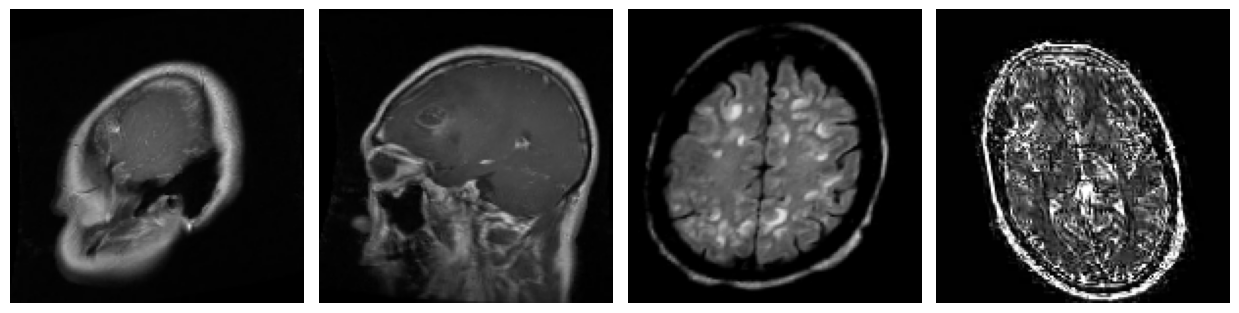

In [ ]:
# Showing augmented images
show_ImageDataGenerator(train_datagen,
                        num_samples=4,
                        figsize=(12.5, 8),
                        save=SAVE)

## <b> 5.2 <span style='border-left: 4px solid #0000FF; padding-left: 10px;'> Training Setup Values <b>

In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# final model epochs
fm_epochs = 50

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Initial Model Epochs: {epochs}')
print(f'Final Model Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Initial Model Epochs: 40
Final Model Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


# **CNN Model 1**

In [ ]:
# Define the model architecture
model_1 = models.Sequential()

# Convolutional layer 1
model_1.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_1.add(Conv2D(64, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_1.add(Conv2D(128, (4, 4), activation="relu"))
model_1.add(Flatten())

# Full connect layers
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.5, seed=SEED))
model_1.add(Dense(class_len, activation="softmax"))

model_1.summary()

# Compile the model
optimizer = legacy.Adam()

model_1.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 49, 49, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 4, 4, 128)        

## <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Training Model <b>

In [ ]:
# Training the model
history_1 = model_1.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps)


Epoch 1/40
178/178 [==============================] - 52s 264ms/step - loss: 0.8627 - accuracy: 0.6079 - val_loss: 0.6661 - val_accuracy: 0.7227
Epoch 2/40
178/178 [==============================] - 45s 255ms/step - loss: 0.5145 - accuracy: 0.7831 - val_loss: 0.5521 - val_accuracy: 0.7773
Epoch 3/40
178/178 [==============================] - 46s 256ms/step - loss: 0.4089 - accuracy: 0.8349 - val_loss: 0.3938 - val_accuracy: 0.8336
Epoch 4/40
178/178 [==============================] - 47s 261ms/step - loss: 0.3229 - accuracy: 0.8787 - val_loss: 0.5070 - val_accuracy: 0.8008
Epoch 5/40
178/178 [==============================] - 46s 258ms/step - loss: 0.2724 - accuracy: 0.8975 - val_loss: 0.2885 - val_accuracy: 0.8875
Epoch 6/40
178/178 [==============================] - 46s 260ms/step - loss: 0.2281 - accuracy: 0.9141 - val_loss: 0.3636 - val_accuracy: 0.8719
Epoch 7/40
178/178 [==============================] - 46s 255ms/step - loss: 0.1919 - accuracy: 0.9319 - val_loss: 0.2227 - val_ac

## <b>  <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Model Evaluation <b>

In [ ]:
# Evaluate the model
loss, accuracy = model_1.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 [==============================] - 2s 49ms/step - loss: 0.0539 - accuracy: 0.9852
Test Loss: 0.05386
Test Accuracy: 0.98516


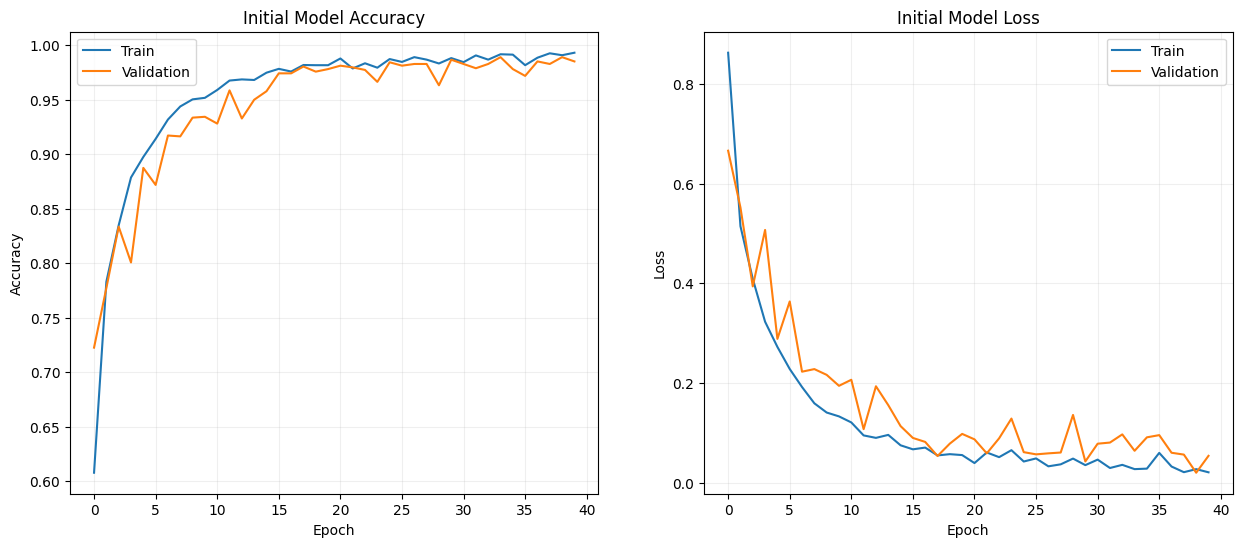

In [ ]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history_1.history['accuracy'])
ax[0].plot(history_1.history['val_accuracy'])
ax[0].set_title('Initial Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history_1.history['loss'])
ax[1].plot(history_1.history['val_loss'])
ax[1].set_title('Initial Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)
if SAVE:
    plt.savefig('model_1_acc_loss.pdf')
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have predictions and true labels after training
predictions = model_1.predict(test_generator)
true_labels = test_generator.classes

# Convert predictions to classes (assuming one-hot encoding)
predicted_classes = np.argmax(predictions, axis=1)


#print(conf_matrix)

# Calculate and display classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("\n CNN Model-1 Classification Report:")
print(report)


41/41 [==============================] - 3s 60ms/step

 CNN Model-1 Classification Report:
              precision    recall  f1-score   support

      glioma       0.99      0.97      0.98       300
  meningioma       0.96      0.98      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      0.99      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.98      0.98      1311
weighted avg       0.99      0.99      0.99      1311



# **Confusion Matrix**

41/41 [==============================] - 2s 47ms/step


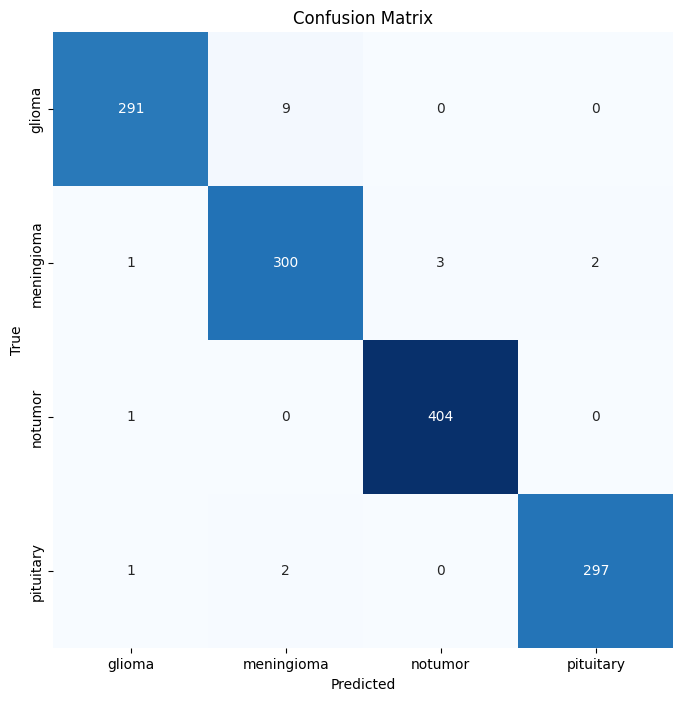

In [ ]:
# Plotting confusion matrix
confusion_matrix_1 = CM(CNN_model=model_1, test_generator=test_generator)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_1, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(class_len) + 0.5, labels=class_indices_train_list, ha='center')
plt.yticks(ticks=np.arange(class_len) + 0.5, labels=class_indices_train_list, va='center')
if SAVE:
    plt.savefig('CM_plot_1.pdf')
plt.show()


# **CNN Model  2**

In [ ]:
# Define the model architecture
model_2 = models.Sequential()

# Convolutional layer 1
model_2.add(Conv2D(32, (4, 4), activation="relu", input_shape=image_shape))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 2
model_2.add(Conv2D(64, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 3
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(MaxPooling2D(pool_size=(3, 3)))

# Convolutional layer 4
model_2.add(Conv2D(128, (4, 4), activation="relu"))
model_2.add(Flatten())

# Full connect layers
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.5, seed=SEED))
model_2.add(Dense(class_len, activation="softmax"))

model_2.summary()

optimizer = legacy.Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)

model_2.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 147, 147, 32)      1568      
                                                                 
 max_pooling2d (MaxPooling2  (None, 49, 49, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 46, 46, 64)        32832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 15, 15, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       131200    
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 4, 4, 128)         0

## <b> <span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Training Model <b>

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_2_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_2_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history_2 = model_2.fit(train_generator,
                        steps_per_epoch=steps_per_epoch,
                        epochs=epochs,
                        validation_data=test_generator,
                        validation_steps=validation_steps,
                        callbacks=[model_2_es, model_2_rlr])


Epoch 1/40
178/178 [==============================] - 50s 261ms/step - loss: 0.8413 - accuracy: 0.6197 - val_loss: 0.6190 - val_accuracy: 0.7508 - lr: 0.0010
Epoch 2/40
178/178 [==============================] - 47s 266ms/step - loss: 0.5141 - accuracy: 0.7910 - val_loss: 0.6061 - val_accuracy: 0.7578 - lr: 0.0010
Epoch 3/40
178/178 [==============================] - 45s 250ms/step - loss: 0.4040 - accuracy: 0.8437 - val_loss: 0.4693 - val_accuracy: 0.7953 - lr: 0.0010
Epoch 4/40
178/178 [==============================] - 45s 251ms/step - loss: 0.3492 - accuracy: 0.8653 - val_loss: 0.4740 - val_accuracy: 0.8148 - lr: 0.0010
Epoch 5/40
178/178 [==============================] - 44s 248ms/step - loss: 0.2654 - accuracy: 0.9044 - val_loss: 0.3737 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 6/40
178/178 [==============================] - 45s 252ms/step - loss: 0.2428 - accuracy: 0.9136 - val_loss: 0.3777 - val_accuracy: 0.8578 - lr: 0.0010
Epoch 7/40
178/178 [==============================] 

In [ ]:
model_file = '/content/drive/MyDrive/CNN_Brain_Tumor/CNN_99_model_2.h5'
history_file = '/content/drive/MyDrive/CNN_Brain_Tumor/history_2.npy'

# Checking for model
if not os.path.exists(model_file):

    # Saving model
    model_2.save(model_file)
    history_dict = history_2.history

    # Save training history as a .npy file
    np.save(history_file, history_dict)

else:
    print('Model exists, please delete if you want to update it.')


Model exists, please delete if you want to update it.


In [ ]:
model_file = '/content/drive/MyDrive/CNN_Brain_Tumor/CNN_99_model_2.h5'
history_file = '/content/drive/MyDrive/CNN_Brain_Tumor/history_2.npy'

# Check if model was created
if os.path.exists(model_file):

    # Loading model 2
    model_2 = models.load_model(model_file)

    # Load the training history from the .npy file
    history_dict = np.load(history_file, allow_pickle=True).item()
    df_history_model_2 = pd.DataFrame(history_dict)
    display( df_history_model_2.head(5) )
    display( df_history_model_2.tail(5) )


,loss,accuracy,val_loss,val_accuracy,lr
0,0.841265,0.619718,0.618983,0.750781,0.001
1,0.514059,0.791021,0.606093,0.757812,0.001
2,0.403996,0.843662,0.469292,0.795313,0.001
3,0.349217,0.865317,0.474029,0.814844,0.001
4,0.265376,0.904401,0.373728,0.852344,0.001


,loss,accuracy,val_loss,val_accuracy,lr
35,0.004239,0.998592,0.076478,0.989844,0.000027
36,0.003533,0.998944,0.074949,0.990625,0.000027
37,0.002836,0.998944,0.074674,0.991406,0.000008
38,0.005020,0.998063,0.073058,0.991406,0.000008
39,0.004175,0.998415,0.072443,0.992188,0.000008


## <b><span style='border-left: 4px solid #0000FF; padding-left: 10px;'>  Model Evaluation <b>

In [ ]:
# Evaluating the model
loss, accuracy = model_2.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 [==============================] - 2s 47ms/step - loss: 0.0724 - accuracy: 0.9922
Test Loss: 0.07244
Test Accuracy: 0.99219


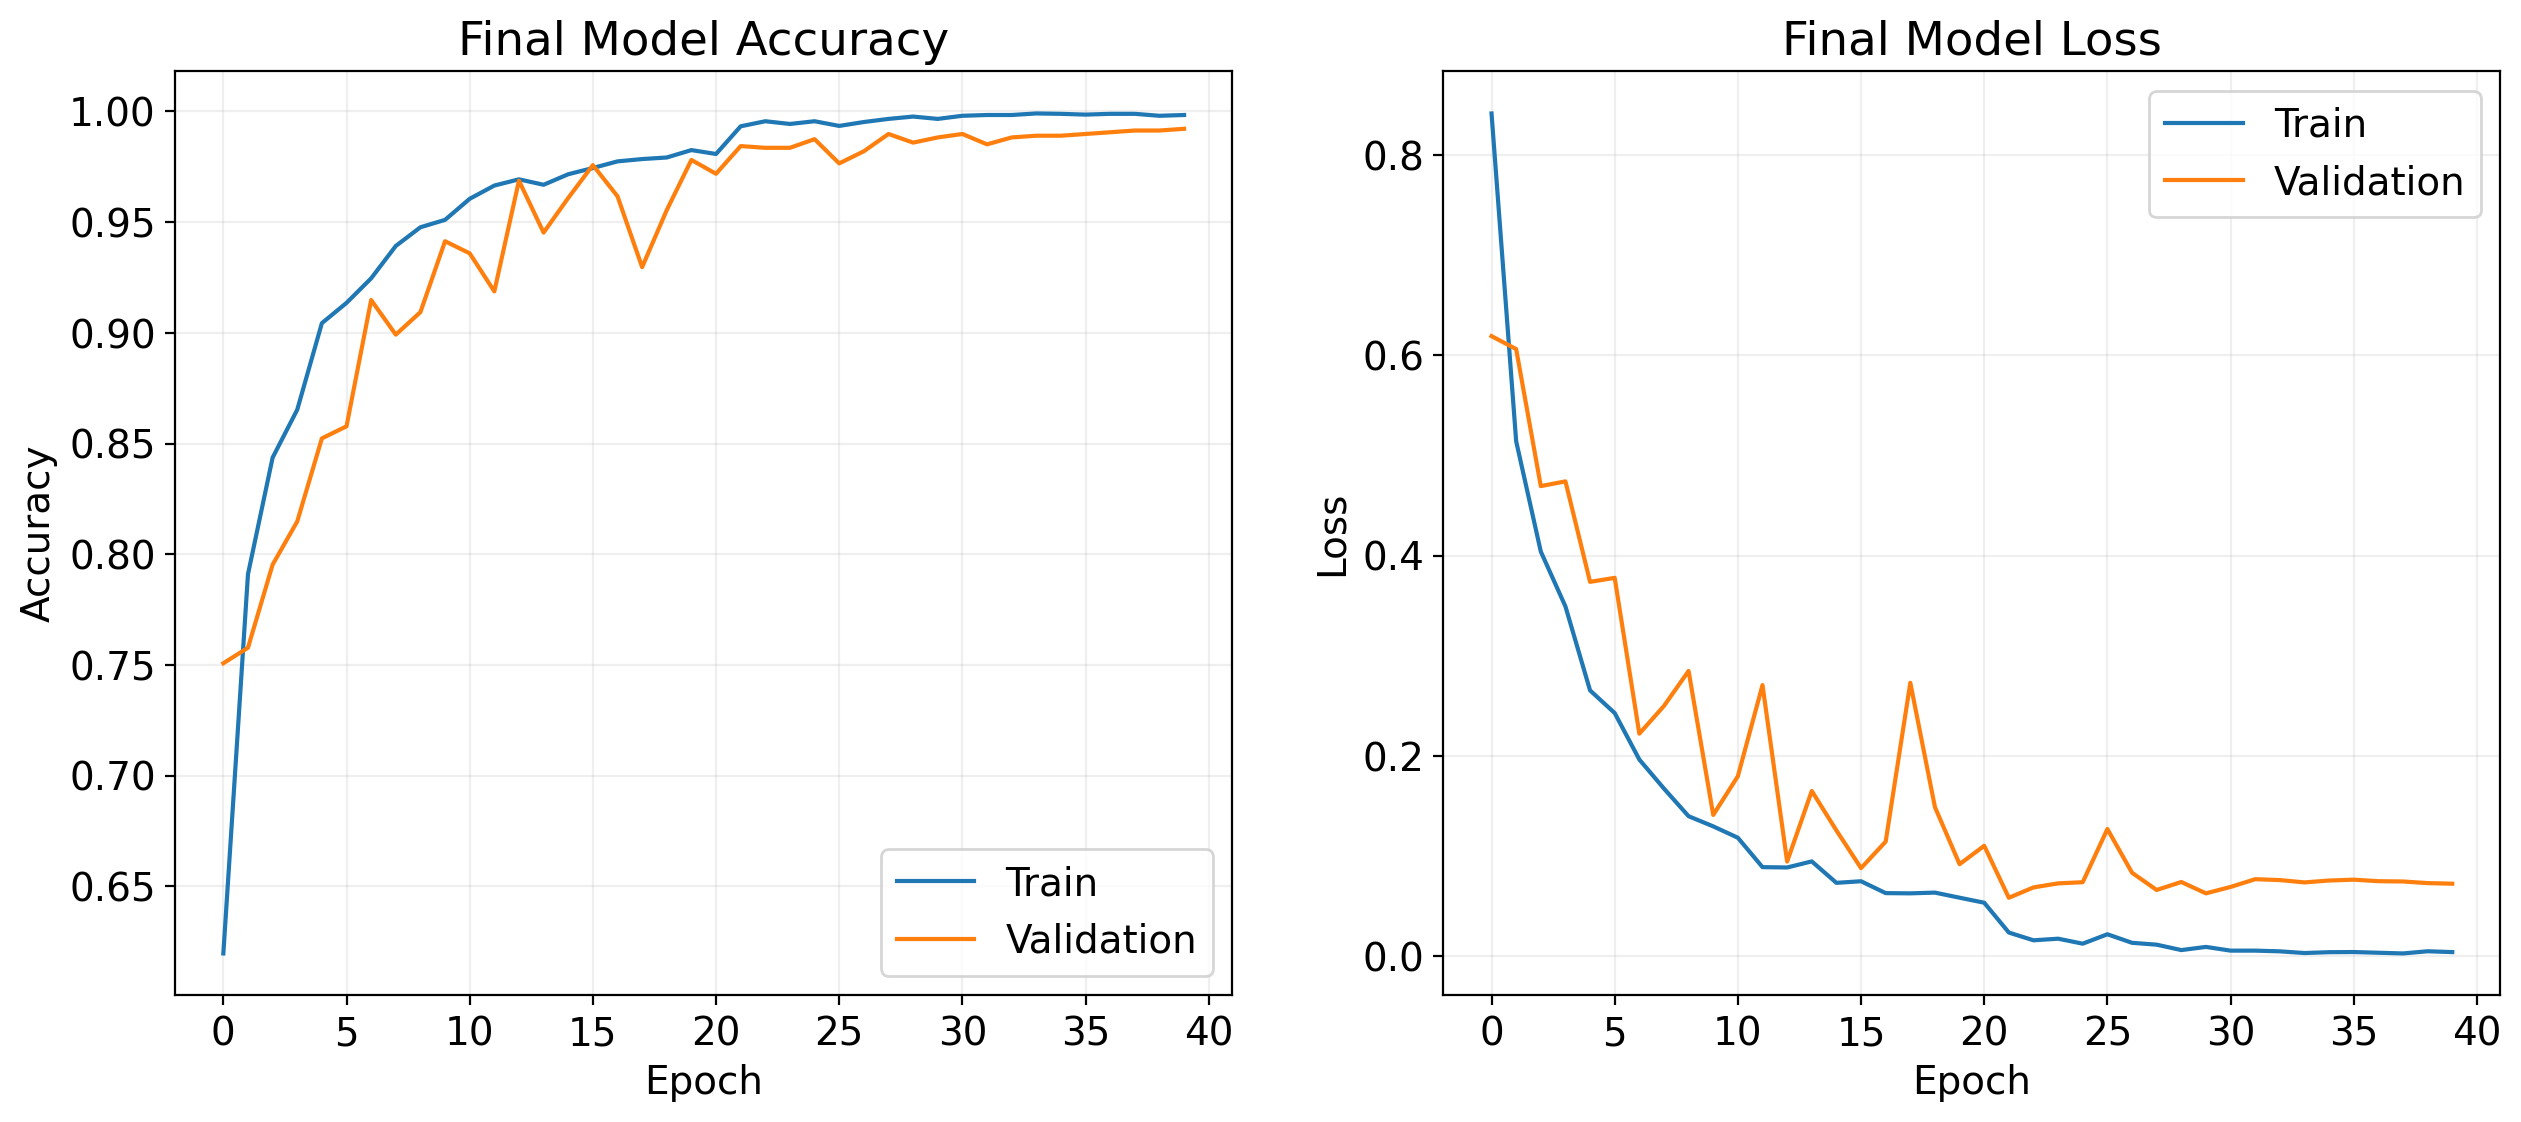

In [ ]:
# checking if from save file or just ran model
if os.path.exists(model_file):
    history = history_dict

else:
    history = history_2.histor

# creating subplots
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plot the training and validation accuracy over epochs
ax[0].plot(history['accuracy'])
ax[0].plot(history['val_accuracy'])
ax[0].set_title('Final Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'])
ax[0].grid(alpha=0.2)

# Plot the training and validation loss over epochs
ax[1].plot(history['loss'])
ax[1].plot(history['val_loss'])
ax[1].set_title('Final Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'])
ax[1].grid(alpha=0.2)
if SAVE:
    plt.savefig('model_2_acc_loss.pdf')
plt.show()

In [ ]:

# Assuming you have predictions and true labels after training
predictions = model_2.predict(test_generator)
true_labels = test_generator.classes

# Convert predictions to classes (assuming one-hot encoding)
predicted_classes = np.argmax(predictions, axis=1)


#print(conf_matrix)

# Calculate and display classification report
class_names = list(test_generator.class_indices.keys())
report = classification_report(true_labels, predicted_classes, target_names=class_names)
print("\n CNN Model-2 Classification Report:")
print(report)


41/41 [==============================] - 2s 47ms/step


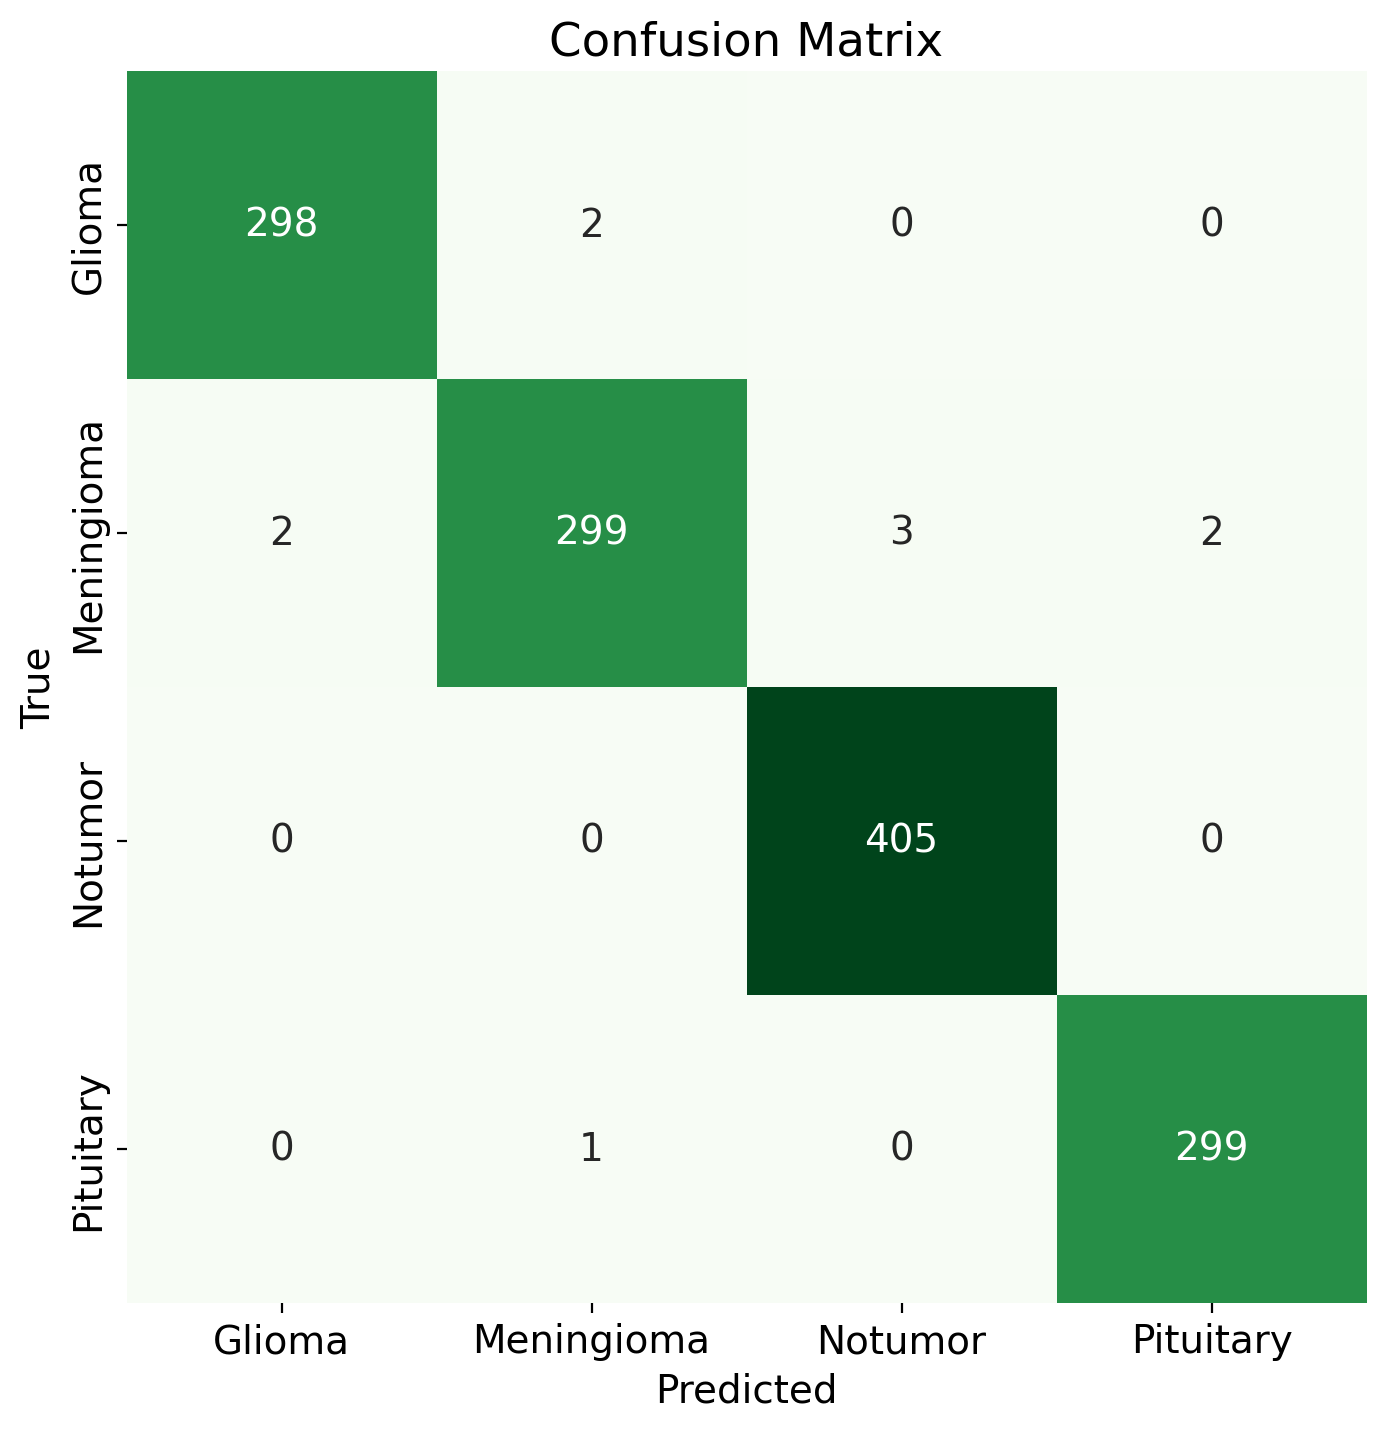

In [ ]:
# Plotting confusion matrix

confusion_matrix_2 = CM(CNN_model=model_2, test_generator=test_generator)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix_2, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(class_len) + 0.5,
           labels=[name.title() for name in class_indices_train_list],
           ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5,
           labels=[name.title() for name in class_indices_train_list],
           va='center')
if SAVE:
    plt.savefig('CM_plot_2.pdf')
plt.show()

# **Prediction**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


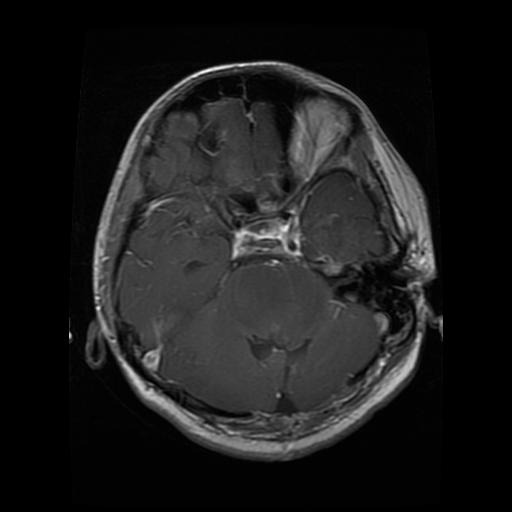

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
Prediction Class :  glioma


In [7]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model
import cv2
import pickle
from google.colab.patches import cv2_imshow
# Load the saved model without the top layers
model = load_model('/content/drive/MyDrive/Brain Tumor/CNN_99_model_2.h5', compile=False)

# Get the index of the flatten layer
flatten_layer_index = None
for i, layer in enumerate(model.layers):
    if isinstance(layer, Flatten):
        flatten_layer_index = i
        break

if flatten_layer_index is None:
    raise ValueError("Flatten layer not found in the model")


img_path='/content/Te-gl_0010.jpg'
image=cv2.imread(img_path)
cv2_imshow(image)
#print(image.shape)
image=cv2.resize(image,(150,150))
#print(image.shape)
image=(image/255).reshape(1,image.shape[0],image.shape[1], -1)
# Extract features using the feature_extractor_model
prediction = model.predict(image)
prediction_val=np.argmax(prediction)


prediction_label={0:'glioma',1:'meningioma',2:'no_tumor',3:'pituitary'}
print("Prediction Class : ",prediction_label.get(prediction_val))